In [ ]:
# Step 1: Install necessary libraries
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph
%pip install -qU "langchain[openai]"
%pip install -qU langchain-openai
%pip install -qU langchain-chroma

In [ ]:
# Step 2: Set up environment variables to start logging traces

import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

··········


In [ ]:
import os
try:
    from google.colab import userdata  # type: ignore
    os.environ.setdefault("OPENAI_API_KEY", userdata.get("OPENAI_API_KEY") or "")
    os.environ.setdefault("SCRAPFLY_API_KEY", userdata.get("SCRAPFLY_API_KEY") or "")
except Exception:
    pass  # Not in Colab or secrets not set

if not os.getenv("OPENAI_API_KEY"):
    print("⚠️ OPENAI_API_KEY is not set. Add it in Colab Secrets or export it in the environment.")
if not os.getenv("SCRAPFLY_API_KEY"):
    print("⚠️ SCRAPFLY_API_KEY is not set. Add it in Colab Secrets or export it in the environment.")

In [ ]:
pip install -qU "langchain[openai]"

In [ ]:
# Step 3: Set up chat model

import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

Enter API key for OpenAI: ··········


In [ ]:
pip install -qU langchain-openai

In [ ]:
# Step 4: Set up embedding model

import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [ ]:
pip install -qU langchain-chroma

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Step 4: Set up vector store

from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [ ]:
# Step 5: Load and chunk contents of the website (working)

import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
# bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://www.reinsurancene.ws/top-100-u-s-property-casualty-insurance-companies/",
               "https://www.iii.org/publications/commercial-insurance/what-it-does/lines-of-business/standard-lines-premiums",
               "https://www.insurancebusinessmag.com/us/news/breaking-news/the-10-largest-pc-commercial-and-personal-lines-insurers-19638.aspx",
               "https://content.naic.org/sites/default/files/pc-and-title-2024mid-year-industry-report.pdf",
               "https://content.naic.org/sites/default/files/research-actuarial-property-casualty-market-share.pdf",
              "https://www.reinsurancene.ws/top-100-u-s-property-casualty-insurance-companies/",
              "https://www.sci-tech-today.com/stats/insurance-industry-statistics/#Type_of_Insurance_Industry_Statistics",
               "https://www.statista.com/statistics/186464/leading-us-commercial-lines-insurance-by-market-share/"),
    # bs_kwargs={"parse_only": bs4_strainer},
)

docs = loader.load()

#assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 9359


In [ ]:
# Step 5: Load and chunk contents of the website (not working)

import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.

loader = WebBaseLoader(
    web_paths=("https://www.reinsurancene.ws/top-100-u-s-property-casualty-insurance-companies/",
               "https://www.iii.org/publications/commercial-insurance/what-it-does/lines-of-business/standard-lines-premiums",
               "https://www.insurancebusinessmag.com/us/news/breaking-news/the-10-largest-pc-commercial-and-personal-lines-insurers-19638.aspx",
               "https://content.naic.org/sites/default/files/pc-and-title-2024mid-year-industry-report.pdf",
               "https://content.naic.org/sites/default/files/research-actuarial-property-casualty-market-share.pdf",
              "https://www.reinsurancene.ws/top-100-u-s-property-casualty-insurance-companies/",
              "https://www.sci-tech-today.com/stats/insurance-industry-statistics/#Type_of_Insurance_Industry_Statistics",
               "https://www.statista.com/statistics/186464/leading-us-commercial-lines-insurance-by-market-share/"),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)


docs = loader.load()

#assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 0


In [ ]:
# Step 5: Print first document

print(docs[0].page_content[:500])














Top 100 U.S. Property & Casualty Insurance Companies - Reinsurance News













































































 













Home
News

#

By combining our experience in knowledge management and reinsurance insight with technology, we aim to bring you the reinsurance industry news that matters online and in our daily emails. Use these categories to find news that interests you, or to view all of our news in chronological order just select “Read


In [ ]:
# Step 6: Splitting documents

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 1184 sub-documents.


In [ ]:
# Step 7: Storing documents

batch_size = 100  # Define a batch size
document_ids = []

for i in range(0, len(all_splits), batch_size):
    batch = all_splits[i:i + batch_size]
    batch_document_ids = vector_store.add_documents(documents=batch)
    document_ids.extend(batch_document_ids)


print(document_ids[:3])

['921a306b-935f-4e74-b726-0ef0e9aa0ff1', '41f8f0c8-6178-4431-9fd7-ebbdf8fd1c01', '2789df41-e8ab-442c-8459-90fd1e075ed2']


In [ ]:
# Step 8: Use a prompt for RAG that is checked into the LangChain prompt hub
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [ ]:
# Step 9: Define state for application to keep track of the input question, retrieved context, and generated answer

from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [ ]:
# Step 10: Define application steps - retrieval and generation

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [ ]:
# Step 11: Compile application into single graph object

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

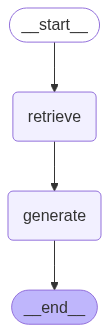

In [ ]:
# Step 12: Visualizing the control flow of application:

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Step 13: Test application using different questions

from IPython.display import Markdown, display

#response = graph.invoke({"question": "List down top 3 Commercial Lines Insurers in 2024?"})
response = graph.invoke({"question": "What is the rank of Hartford by net written premium in 2023? Also mention tge net written premium of Hartford in 2023."})
#response = graph.invoke({"question": "What is the rank of Progressive insurance?"})
#response = graph.invoke({"question": "List down TOP TEN WRITERS OF COMMERCIAL LINES INSURANCE BY DIRECT PREMIUMS WRITTEN, 2008. Also mention respective direct written premiums"})
#response = graph.invoke({"question": "List down top 3 Commercial Lines Insurers in 2024?"})

display(Markdown(f"Context: {response['context']}\n\n"))
display(Markdown(f"Answer: {response['answer']}"))

Context: [Document(id='e605c5df-81af-4a52-be25-b500b8802e27', metadata={'title': 'Standard Lines Premiums | III', 'description': 'The commercial lines sector of the property/casualty insurance industry generally provides insurance products for businesses as opposed to the personal lines sector, which offers products for individuals and households. However, the division between commercial and personal coverages is not precise. For example, inland marine insurance, which is included in the commercial lines', 'start_index': 17460, 'language': 'No language found.', 'source': 'https://www.iii.org/publications/commercial-insurance/what-it-does/lines-of-business/standard-lines-premiums'}, page_content='2016\n34,035,048\n-1.8\n2021\n43,743,627\n6.9\n\n\n2017\n34,133,989\n0.3\n2022\n48,416,980\n10.7\n\n\n2018\n37,487,056\n9.8\n2023\n54,608,768\n13.0\n\n\n2019\n38,874,249\n3.7\n2024\n58,279,674\n6.8\n\n\n\n\nNonliability portion\n\n\nYear\nNet premiums\nwritten (1)\nAnnual percent\nchange\nCombined\nratio (2)\nAnnual point\nchange (3)\nYear\nNet premiums\nwritten (1)\nAnnual percent\nchange\nCombined\nratio (2)\nAnnual point\nchange (3)\n\n\n\n\n2015\n$21,401,338\n-2.0%\n91.9\n-5.3 pts.\n2020\n$25,589,527\n9.9%\n112.2\n9.2 pts.\n\n\n2016\n20,762,324\n-3.0\n98.3\n6.4\n2021\n27,297,914\n6.7\n109.2\n-3.0\n\n\n2017\n20,619,726\n-0.7\n111.9\n13.7\n2022\n30,354,005\n11.2\n103.7\n-5.6\n\n\n2018\n22,500,592\n9.1\n108.4\n-3.5\n2023\n35,298,186\n16.3\n105.4\n1.7\n\n\n2019\n23,281,516\n3.5\n103\n-5.4\n2024\n38,276,901\n8.4\n91.6\n-13.8\n\n\n\n\n\xa0\nLiability portion\n\n\nYear\nNet premiums\nwritten (1)\nAnnual percent\nchange\nCombined\nratio (2)\nAnnual point\nchange (3)\nYear\nNet premiums\nwritten (1)\nAnnual percent\nchange\nCombined\nratio (2)\nAnnual point\nchange (3)'), Document(id='1498a0fc-c073-41dd-908c-1bb69bf8dbd2', metadata={'description': 'FIO reveals the largest commercial and personal lines insurance providers in the P&C space. Find out where the top insurance brands rank', 'title': 'The 10 largest P/C commercial and personal lines insurers | Insurance Business America', 'language': 'en', 'source': 'https://www.insurancebusinessmag.com/us/news/breaking-news/the-10-largest-pc-commercial-and-personal-lines-insurers-19638.aspx', 'start_index': 15124}, page_content='7. CNA\nDirect premiums written: $12.8 billion\nMarket share: 2.84%\n\n\n\n\nCNA Insurance offers commercial insurance and risk management solutions tailored to suit the unique needs of each business. Its portfolio includes commercial auto, cyber, liability, marine, and workers’ compensation insurance. CNA operates in more than 70 locations in the US, Canada, and Europe.\n\n\n\n\n\n\n\n\n\n8. The Hartford\nDirect premiums written: $11.8 billion\nMarket share: 2.61%\n\n\n\n\nThe Hartford’s commercial lines policies cater to a wide range of industries, including education, healthcare, manufacturing, retail, and technology. Among the products in the Connecticut-based insurer’s portfolio are auto, property, data breach, general and professional liability, and workers’ compensation. The Hartford often receives positive reviews for its customer service.\n\n\n\n\n\xa0\n\n\n\n\n9. Progressive\nDirect premiums written: $10.9 billion\nMarket share: 2.43%'), Document(id='62c4e9f7-1bec-4f18-82e3-acf58071d328', metadata={'start_index': 2884, 'language': 'No language found.', 'description': 'The commercial lines sector of the property/casualty insurance industry generally provides insurance products for businesses as opposed to the personal lines sector, which offers products for individuals and households. However, the division between commercial and personal coverages is not precise. For example, inland marine insurance, which is included in the commercial lines', 'source': 'https://www.iii.org/publications/commercial-insurance/what-it-does/lines-of-business/standard-lines-premiums', 'title': 'Standard Lines Premiums | III'}, page_content='3\nLiberty Mutual\n19,970,975\n4.0\n\n\n4\nBerkshire Hathaway Inc.\n19,202,724\n3.8\n\n\n5\nZurich Insurance Group\n17,991,721\n3.6\n\n\n6\nAmerican International Group (AIG)\n14,151,844\n2.8\n\n\n7\nHartford Financial Services\n13,829,345\n2.8\n\n\n8\nCNA Financial Corp.\n13,450,851\n2.7\n\n\n9\nProgressive\n12,547,795\n2.5\n\n\n10\nTokio Marine\n10,255,294\n2.1\n\n\n\n\n\n\n\n(1) Before reinsurance transactions, includes state funds.\n(2) Based on U.S. total, excluding territories.\nSource: NAIC data, sourced from S&P Global Market Intelligence, Insurance Information Institute.\n\n\n\n\nView Archived Tables \n\n\n\n    \t      Top 10 Commercial Insurance Brokers Of U.S. Business By Revenue, 2024 (1)          \n \n\n\n\n\n($ millions)\n\n\n\n\n\n\n\n\n\n\n\n\nRank\nCompany\nBrokerage revenues\n\n\n\n\n1\nMarsh & McLennan Cos. Inc. (2), (3)\n$12,666\n\n\n2\nAon PLC (2), (4)\n7,497\n\n\n3\nArthur J. Gallagher & Co. (2)\n7,092\n\n\n4\nWillis Towers Watson PLC\n5,064\n\n\n5\nAlliant Insurance Services Inc. (2)\n4,970\n\n\n6\nBrown & Brown Inc. (2)\n4,037\n\n\n7\nHub International Ltd. (2)\n3,814'), Document(id='e0374714-92f8-40aa-acac-5f99e7a627c0', metadata={'start_index': 10376, 'title': 'Market share of U.S. commercial insurers 2023| Statista', 'description': 'In 2023, Chubb Ltd led the commercial lines insurance market in the United States, ahead of Travelers Companies Inc.', 'source': 'https://www.statista.com/statistics/186464/leading-us-commercial-lines-insurance-by-market-share/', 'language': 'en'}, page_content='Read more\n                                            \n                            Advertisement\n                        \n                            Advertisement\n                        \n                                                    Market share of commercial lines insurance companies in the United States from 2021 to 2023, by direct premiums written\n                                            \n                                    table\n                                \n                                    column chart\n                                Characteristic202120222023*Chubb Ltd.5.6%5.7%5.5%Travelers Companies Inc.4.9%5%5.2%Liberty Mutual4.9%4.6%4.3%Berkshire Hathaway Inc.3.3%3.8%4%Zurich Insurance Group3.7%4%3.9%American International Group (AIG)3.3%3.1%3%CNA Financial Corp. 3%2.8%2.7%Hartford Financial Services2.7%2.7%2.7%Progressive2.6%2.5%2.5%Nationwide Mutual Group2.4%2.4%-\tTokio Marine--2.1%')]



Answer: In 2023, Hartford ranked 7th by net written premium, with a total of $13.8 billion.